# Arsh Misra

# Lab #1

In [ ]:
#importing GSS dataset using code from lecturer python file
import zipfile
import pandas as pd
import requests
import io
from tqdm.notebook import tqdm

from __future__ import division
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import os
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
import seaborn as sns

# Step 1: Download the ZIP file with progress bar
url = 'https://gss.norc.org/content/dam/gss/get-the-data/documents/stata/2006_stata.zip'

# Make a streaming request to get the content in chunks
response = requests.get(url, stream=True)
total_size = int(response.headers.get('content-length', 0))  # Get the total file size
block_size = 1024  # 1 Kilobyte

# Progress bar for downloading
tqdm_bar = tqdm(total=total_size, unit='iB', unit_scale=True)
content = io.BytesIO()

# Download the file in chunks with progress bar
for data in response.iter_content(block_size):
    tqdm_bar.update(len(data))
    content.write(data)

tqdm_bar.close()

# Check if the download is successful
if total_size != 0 and tqdm_bar.n != total_size:
    print("Error in downloading the file.")
else:
    print("Download completed!")

# Step 2: Extract the ZIP file in memory and display progress
with zipfile.ZipFile(content) as z:
    # List all files in the zip
    file_list = z.namelist()

    # Filter for the .dta file (assuming there is only one)
    stata_files = [file for file in file_list if file.endswith('.dta')]

    # If there is a Stata file, proceed to extract and read it
    if stata_files:
        stata_file = stata_files[0]  # Take the first .dta file

        # Step 3: Load the dataset without 'hhtype'
        with z.open(stata_file) as stata_file_stream:
            # First, read the file to get all column names
            print("Loading dataset to determine columns...")
            df_columns = pd.read_stata(stata_file_stream, convert_categoricals=False, iterator=True)

            # Get all column names and exclude 'hhtype'
            all_columns = df_columns.variable_labels().keys()
            columns_to_load = [col for col in all_columns if col != 'hhtype']

        # Reload the file to load only the selected columns
        with z.open(stata_file) as stata_file_stream:
            print("Loading dataset with numeric labels excluding 'hhtype'...")
            df_numeric = pd.read_stata(stata_file_stream, columns=columns_to_load, convert_categoricals=False)
            print("Data with numeric labels loaded successfully!")

        # Reload the file again to load only the selected columns with categorical labels
        with z.open(stata_file) as stata_file_stream:
            print("Loading dataset with string (categorical) labels excluding 'hhtype'...")
            df_categorical = pd.read_stata(stata_file_stream, columns=columns_to_load)

            # Step to rename categorical columns with a 'z' prefix
            df_categorical = df_categorical.rename(columns={col: f'z{col}' for col in df_categorical.columns})
            print("Categorical columns renamed with 'z' prefix.")

# Step 4: Concatenate both numeric and categorical dataframes
df = pd.concat([df_numeric, df_categorical], axis=1)
df.head()

  0%|          | 0.00/1.67M [00:00<?, ?iB/s]

Download completed!
Loading dataset to determine columns...
Loading dataset with numeric labels excluding 'hhtype'...
Data with numeric labels loaded successfully!
Loading dataset with string (categorical) labels excluding 'hhtype'...
Categorical columns renamed with 'z' prefix.


,year,id,wrkstat,hrs1,hrs2,evwork,wrkslf,wrkgovt,occ80,prestg80,...,zspaneng,zwtss,zwtssnr,zwtssall,zvstrat,zvpsu,zwtssps,zwtssnrps,zfileversion,zyearval1
0,2006,1,1.0,35.0,NaN,NaN,2.0,2.0,95.0,66.0,...,english,0.43,0.49,0.4297,1957,1,0.505483,0.524713,7222.31,NaN
1,2006,2,1.0,40.0,NaN,NaN,2.0,2.0,243.0,44.0,...,english,1.91,2.16,1.9096,1957,1,2.090907,2.102368,7222.31,NaN
2,2006,3,5.0,NaN,NaN,1.0,2.0,2.0,715.0,29.0,...,spanish,0.86,0.97,0.8593,1957,1,1.448735,1.445360,7222.31,NaN
3,2006,4,2.0,24.0,NaN,NaN,2.0,2.0,313.0,46.0,...,english,0.43,0.49,0.4297,1957,1,0.385372,0.409203,7222.31,NaN
4,2006,5,6.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,...,english,1.29,1.46,1.2890,1957,1,1.387133,1.396702,7222.31,NaN


In [ ]:
#1-- Choose one variable, look at its distribution (mean, sd, median, min, max),
#or if it is categorical, create a simple table for it, and plot it with a histogram.
# Explain what you take away from looking at the variable.

#getting percentages of the instances of all unique values in the hrs1 variable.
df.hrs1.value_counts(normalize=True).sort_index()*100



,proportion
hrs1,
1.0,0.146039
2.0,0.036510
3.0,0.073019
4.0,0.292077
5.0,0.182548
...,...
84.0,0.036510
85.0,0.109529
86.0,0.036510


In [ ]:
#1-- Choose one variable, look at its distribution (mean, sd, median, min, max), or
# if it is categorical, create a simple table for it, and plot it with a histogram.
# Explain what you take away from looking at the variable.

df[['hrs1']].describe()

# we get a mean of around 42.07, standard deviation of around 14.23, median of 40.00
#(Q2 or 50%), and a min of 1.00 and a max of 89.00.




,hrs1
count,2739.000000
mean,42.076305
std,14.231662
min,1.000000
25%,38.000000
50%,40.000000
75%,50.000000
max,89.000000


In [ ]:
na_count = df['hrs1'].isna().sum()
print(na_count)
#1771 missing values

min_value = df['hrs1'].min()
print(min_value)
#The minimum value had to be calculated separately. I'm not quite sure why this is but I just calculated it separately.
# min found to be 1.0.
#hrs1 is the number of hours worked per week at all jobs by respondents.
#What we see is that the average work week consists of around 42.07 hours.
#This variable includes part-time workers, which might drive the average down a bit.
#What indicates that this might be the case is
#because the standard deviation is 14.23, which is quite a large spread/variation in work hours.
#This is anticipated because there is usually a significant gap between part-time hours and full-time hours.
#We could create new variables that would separate the part-time and
#full-time workers so we can see the average work-week for these two groups.
#Additionally, NA values are quite high in this variable because each NA value represents
#retired workers, technically making their values 0 but in this case it is listed as NA so that they don't cause underestimations.
#the work weeks of respondents in 2006 can provide valuable information about potential work-life balance, economic prosperity,
#and other factors if we introduce comparisons.
#For example, we could compare work week hours to a categorical variable describing exhaustion level to see whether there is a
# correlation between hours worked and exhaustion level.

1771
1.0


In [ ]:
df.groupby(['xhaustn'])['hrs1'].mean()

#in this code I calculated the mean hours worked for each exhaustion level, 1-5.
#With 1 being the highest level of exhaustion and 5 being the lowest level.
#We can see in the table below that there seems to be a semi-strong correlation between exhaustion levels
# and work hours except for the 2.0 level, which increases despite a decrease in exhaustion level.
#This could be due to a number of factors but it is difficult to know exactly what and why.
#To summarize, exhaustion levels appear to decrease as the work hours decrease, which makes sense.
#As for the standard deviation, the spread of hours worked per week in each exhaustion level are quite similar and
# doesn't differ by more than approximately 2 hours for each exhaustion level.
#We do see that the std for each level is more than 10 hours, which indicates a significant
#degree of variability for each exhaustion level.



,hrs1
xhaustn,
1.0,44.865672
2.0,46.293617
3.0,41.013730
4.0,39.803738
5.0,31.718750


In [ ]:
df.groupby(['xhaustn'])['hrs1'].std()




,hrs1
xhaustn,
1.0,15.060675
2.0,13.205597
3.0,11.463136
4.0,13.546871
5.0,16.166940


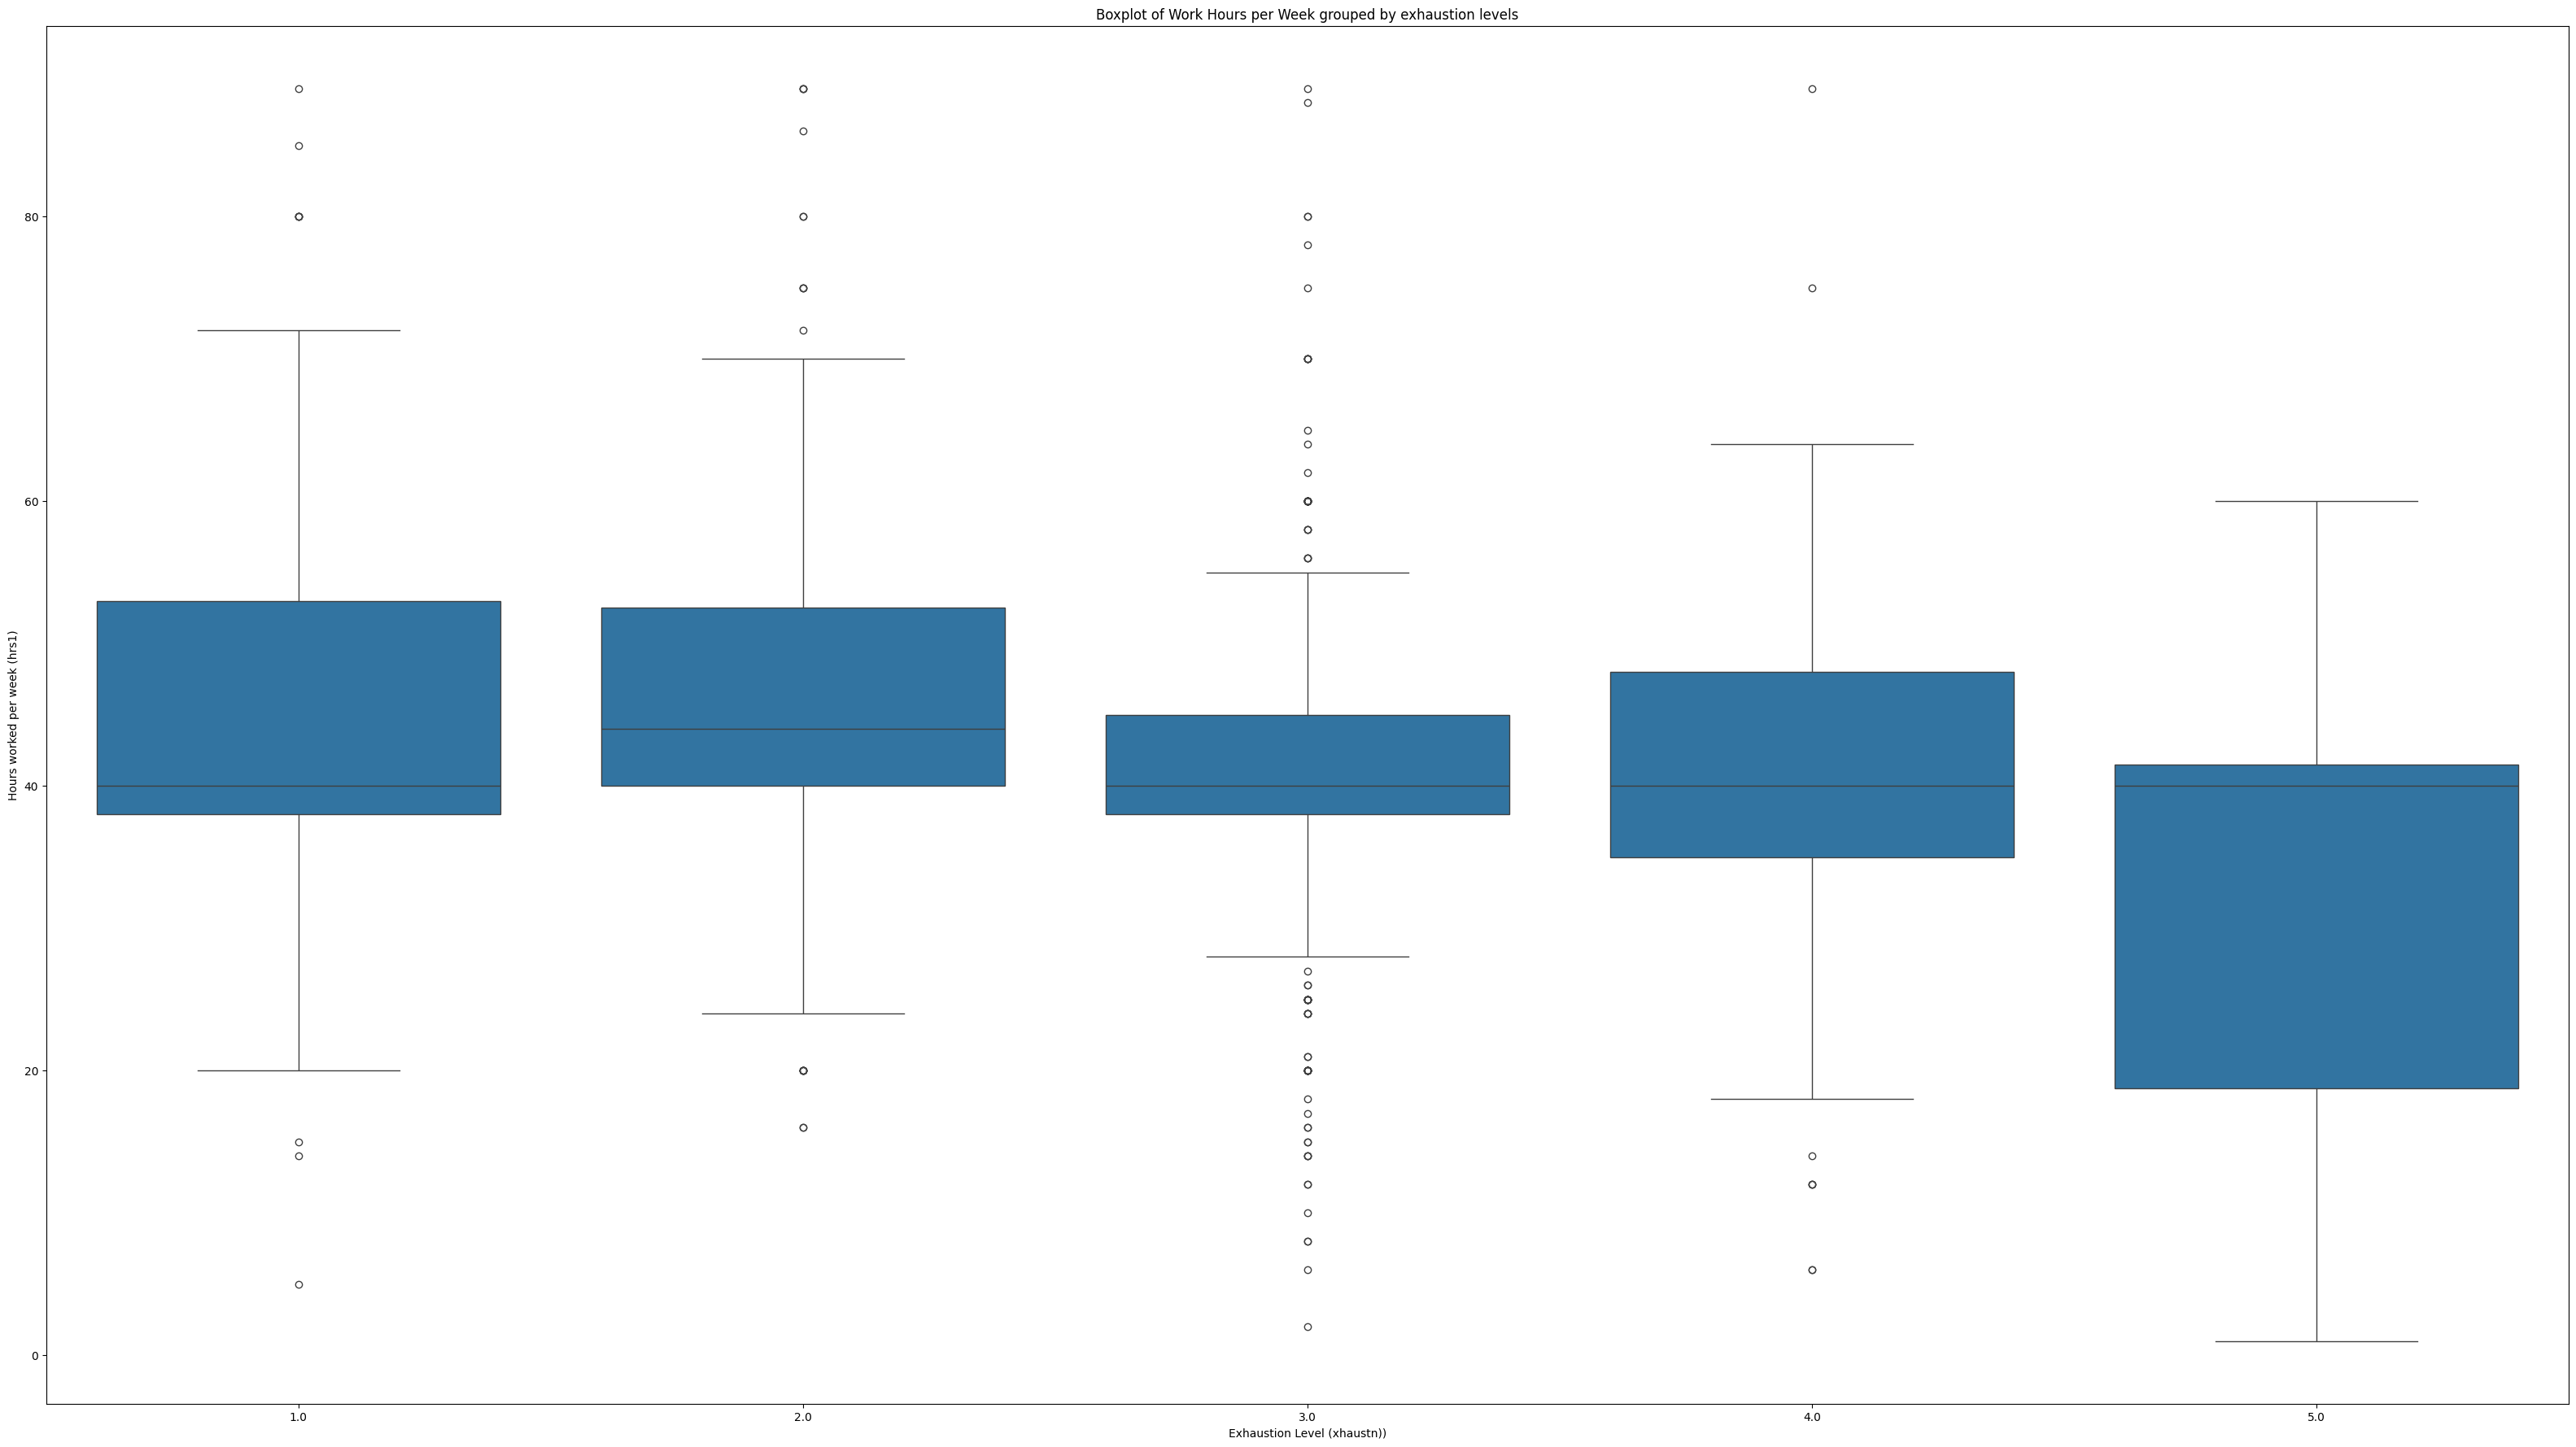

In [ ]:
plt.figure(figsize=(40, 22))
sns.boxplot(y='hrs1', x='xhaustn', data=df)
plt.title('Boxplot of Work Hours per Week grouped by exhaustion levels')
plt.xlabel('Exhaustion Level (xhaustn))')
plt.ylabel('Hours worked per week (hrs1)')
plt.show()

#We can see the distribution of work hours on average for each exhaustion level in the box plots below.
#There are some outliers here and there, the most seemingly in level 3.0.
#For some exhaustion levels, such as level 5.0,
# work hours vary significantly. This may indicate that for
#extremely low exhaustion levels the variability in work hours is quite large. However, for
#exhaustion levels 1,2, and 4, while there is a degree of variation in work hours per week no correlation between levels is noticeable.
# Level 3.0 is also observed as having a much smaller variation in work hours.
#None of the whiskers in all plots are heavily skewed, which suggests that the outside 50% of the data is relatively evenly distributed.
#Inside the box, there is a degree of positive skewness,
#as the median line is closer to the bottom of the box.
#This indicates that while a large portion of respondents work around the median number of hours, some people work significantly more hours,
#which is pulling the distribution upward and causing the plots to be positively skewed.
#We conclude that levels 1,2,4, and 5 of the exhaustion level scale have significant variability
# in the number of hours worked per week, which may indicate underlying factors
#This could include the idea that different professions may be more exhausting than others or
#each respondent may have different tolerance levels.
#however, the 3.0 level has a low degree of variability.
#This may be because many people with jobs that have
#standardized work hours may have similar exhaustion levels.
# But this is difficult to determine without further analysis.
# you could test this with more quantifiable variables like age,sex, profession, or wellbeing levels.


In [ ]:
# 3. Choose two categorical-ish variables, and cross-tabulate them.  Plot them using a stacked bar chart.
#Explain what conclusion you draw from this analysis
xhaustn_physwrk_counts = df.groupby(['xhaustn', 'physwrk']).size()

physwrk_counts = df.groupby('physwrk').size()

# Calculate the percentage
d_pct = xhaustn_physwrk_counts / physwrk_counts
# cross-tabulating
print(d_pct)


xhaustn  physwrk
1.0      1.0        0.462687
         2.0        0.185841
         3.0        0.100877
         4.0        0.080508
         5.0        0.085246
2.0      1.0        0.238806
         2.0        0.362832
         3.0        0.263158
         4.0        0.254237
         5.0        0.190164
3.0      1.0        0.253731
         2.0        0.407080
         3.0        0.574561
         4.0        0.474576
         5.0        0.465574
4.0      1.0        0.037313
         2.0        0.044248
         3.0        0.048246
         4.0        0.169492
         5.0        0.180328
5.0      1.0        0.007463
         3.0        0.013158
         4.0        0.021186
         5.0        0.078689
dtype: float64


<Axes: xlabel='xhaustn'>

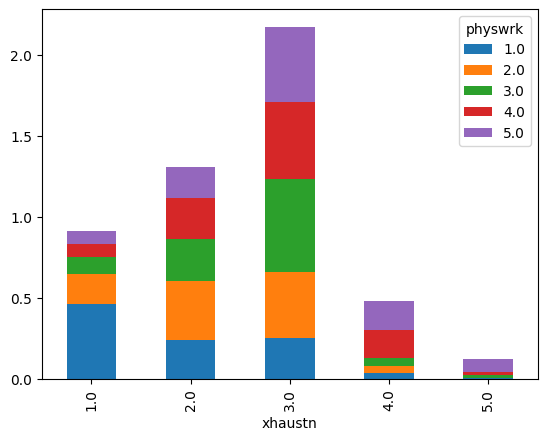

In [ ]:
# Unstack and plot the data
d_pct.unstack().plot(kind='bar', stacked=True)
#there are two variables here, the xhaustn variable describes respondents who said how exhausted
#they were after coming home from work on a scale of 1 to 5 like previously mentioned.
#The physwrk variable indicates how much physical work respondents have to do for their jobs on a scale of 1-5.
# With 1 being the highest and 5 being the lowest once again.
#The most exhausting jobs appear to be the ones that require the most physical work.
#If we check the 1.0 levels for both variables, we see that the jobs with the highest level of physical work
#may be associated with the highest level of exhaustion (0.46 share). However, for the intermediate levels it is not as prominent.
#If we look in reverse, the 5.0 level also shows that the lowest level of physical work indicates the lowest share of 1.0 (0.007)
# and the highest share of 5.0 (0.07).
# This indicates that the jobs with the lowest level of physical work may be associated with lower exhaustion levels.
#For the middle levels there is a much higher degree of variability between each physical work level, especially levels 2 and 3.
#This may be because the level of physical work is not as extreme and thus the level of exhaustion
# may be more susceptible to people's own opinions.
#in short, for the middle levels other factors seem to be at play here while there appears to be a more distinct correlation
# between hours worked per week and exhaustion level.

In [ ]:
#lab one complete
#Do let me know if you have any questions about this. I tried to make it as
#clear as possible but there are probably some areas of improvement.
#This was a fun exercise!


Do not mind this text it is simply to ensure that the bar chart above is not cut off:
#################################################################
################################################################
#################################################################
###############################################################
###############################################################
#############################################################